# Results - Classification on experimental data
This notebook is the primary source of plots and tables for the classificationn part of the thesis, 
with the goal of keeping every table and figure as standardized as possible. 
## Questions
* Descriptive statistics
    - Should descriptive statistics of the simulated data be included?\
    If so, how much? And should it be included for each fold in the k-fold cross-validation?
* Classification results
    - Breakdown of results based on event type? Single, double, close double?
    Reasonable to include in order to confirm the assumption that close doubles are the
    most difficult event type to classify correctly in simulated data
    Random state is included, so should be simple to reproduce the indices


## Handy links
* [matplotlib-plots to latex](https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/)
* [Robert's thesis df output](https://github.com/ATTPC/VAE-event-classification/blob/master/src/make_classification_table.py)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import *
from master_scripts.analysis_functions import *
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

THESIS_PATH = "../../../master_thesis/"

In [2]:
# Load experimental set and normalize
repo_root = get_git_root()
events, images = import_real_data(repo_root + "data/real/anodedata_500k.txt") # images not normalized
images = normalize_image_data(images)

In [3]:
def classify(model, images, events, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"

    return events

def classification_metrics(model, images, events, name, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"
            
    descriptors = list(set([event['event_descriptor'] for event in events.values()]))
    
    desc_class = {'single': [], 'double': []}
    for event in events.values():
        desc_class[event['event_class']].append(event['event_descriptor'])
    
    translate_descriptor = {
        1: "Implant",
        2: "Decay",
        3: "implant + Decay",
        4: "Light ion",
        5: "Implant + Light Ion",
        6: "Decay + Light Ion",
        7: "Implant + Decay + Light Ion",
        8: "Double (time)",
        9: "Implant + Double (time)",
        10: "Decay + Double (time)",
        11: "Implant + Decay + Double (time)",
        12: "Light ion + Double (time)",
        13: "Implant + Light Ion + Double (time)",
        14: "Decay + Light ion + Double (time)",
        15: "Implant + Decay + Light Ion + Double (time)",
        16: "Double (space)",
        17: "Implant + Double (space)",
        18: "Decay + Double (space)"
    }
    
    results = {}
    for d in descriptors:
        num_s = desc_class['single'].count(d)
        num_d = desc_class['double'].count(d)
        tot = num_s + num_d
        norm_s = num_s / tot
        norm_d = num_d / tot
        results[translate_descriptor[d]] = [
            num_s,
            num_d,
            norm_s,
            norm_d
        ]
    
    cols = ["Predicted single", "Predicted double", "Normalized single", "Normalized double"]
    df = pd.DataFrame.from_dict(data=results, orient='index', columns=cols)
    return df


# Pre-processed simulated data - no additional modifications
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.

## Logistic regression

In [51]:
# Load logistic regression experiment
log_ex_id = "003e1b62336e"
log_ex = load_experiment(log_ex_id)

# Load model and predict
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test = classification_metrics(log_model, images.reshape(images.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [52]:
# Load logistic regression experiment
dense_ex_id = "c19117f62bd8"
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test = classification_metrics(dense_model, images.reshape(images.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [53]:
# Load logistic regression experiment
cnn_ex_id = "b56e64ac3b1c"
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test = classification_metrics(cnn_model, images, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [54]:
# Load pretrained regression experiment
pretrained_ex_id = "c96f61c743c2"
pretrained_ex = load_experiment(pretrained_ex_id)

pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test = classification_metrics(pretrained_model, np.concatenate((images, images, images), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [55]:
# Load custom classification experiment
custom_ex_id = "424cc250c5ab"
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test = classification_metrics(custom_model, images, events, "custom_test")
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [94]:
all_decays = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test.iloc[1],
        'Dense': dense_test.iloc[1],
        'CNN': cnn_test.iloc[1],
        'Pretrained': pretrained_test.iloc[1],
        'Custom': custom_test.iloc[1],
    },
    orient='index'
)

all_labeled_doubles = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test.iloc[-1],
        'Dense': dense_test.iloc[-1],
        'CNN': cnn_test.iloc[-1],
        'Pretrained': pretrained_test.iloc[-1],
        'Custom': custom_test.iloc[-1],
    },
    orient='index'
)

display(all_decays)
display(all_labeled_doubles)

,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,198210.0,61937.0,0.761915,0.238085
Dense,97487.0,162660.0,0.374738,0.625262
CNN,63051.0,197096.0,0.242367,0.757633
Pretrained,138614.0,121533.0,0.532830,0.467170
Custom,26277.0,233870.0,0.101008,0.898992


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,0.0,17.0,0.0,1.0
Dense,0.0,17.0,0.0,1.0
CNN,0.0,17.0,0.0,1.0
Pretrained,0.0,17.0,0.0,1.0
Custom,0.0,17.0,0.0,1.0


# Pre-processed simulated data - Pixel modified
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

## Logistic regression

In [57]:
# Load logistic regression experiment
log_ex_id = "b89547da983e"
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test_pmod = classification_metrics(log_model, images.reshape(images.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [58]:
# Load logistic regression experiment
dense_ex_id = "bc4937925065"
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_pmod = classification_metrics(dense_model, images.reshape(images.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [59]:
# Load logistic regression experiment
cnn_ex_id = "2b135384dd50"
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_pmod = classification_metrics(cnn_model, images, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [60]:
# Load logistic regression experiment
pretrained_ex_id = "6bc44ed76ea7"
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_pmod = classification_metrics(pretrained_model, np.concatenate((images, images, images), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [61]:
# Load custom classification experiment
custom_ex_id = "60f95ed56212"
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_pmod = classification_metrics(custom_model, images, events, "custom_test")
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [95]:
all_decays_pmod = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test_pmod.iloc[1],
        'Dense': dense_test_pmod.iloc[1],
        'CNN': cnn_test_pmod.iloc[1],
        'Pretrained': pretrained_test_pmod.iloc[1],
        'Custom': custom_test_pmod.iloc[1],
    },
    orient='index'
)

all_labeled_doubles_pmod = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test_pmod.iloc[-1],
        'Dense': dense_test_pmod.iloc[-1],
        'CNN': cnn_test_pmod.iloc[-1],
        'Pretrained': pretrained_test_pmod.iloc[-1],
        'Custom': custom_test_pmod.iloc[-1],
    },
    orient='index'
)

display(all_decays_pmod)
display(all_labeled_doubles_pmod)

,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,202426.0,57721.0,0.778122,0.221878
Dense,100778.0,159369.0,0.387389,0.612611
CNN,66790.0,193357.0,0.256739,0.743261
Pretrained,137765.0,122382.0,0.529566,0.470434
Custom,24738.0,235409.0,0.095092,0.904908


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,0.0,17.0,0.0,1.0
Dense,0.0,17.0,0.0,1.0
CNN,0.0,17.0,0.0,1.0
Pretrained,0.0,17.0,0.0,1.0
Custom,0.0,17.0,0.0,1.0


# Pre-processed simulated data - Pixel modified and imbalanced
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

This dataset has also been purposefully imbalanced to mimic the properties of experimental data
where doubles in space are expected to be rare.

## Logistic regression

In [63]:
# Load logistic regression experiment
log_ex_id = "f7f88d576358"
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test_imbalanced = classification_metrics(log_model, images.reshape(images.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [64]:
# Load logistic regression experiment
dense_ex_id = "eda9d70f103d"
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_imbalanced = classification_metrics(dense_model, images.reshape(images.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [65]:
# Load logistic regression experiment
cnn_ex_id = "fbec3ae91aaa"
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_imbalanced = classification_metrics(cnn_model, images, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [66]:
# Load logistic regression experiment
pretrained_ex_id = "63d7c8bf7564"
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_imbalanced = classification_metrics(pretrained_model, np.concatenate((images, images, images), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [67]:
# Load custom classification experiment
custom_ex_id = "5f6eef7315ab"
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_imbalanced = classification_metrics(custom_model, images, events, "custom_test")
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [96]:
all_decays_imbalanced = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test_imbalanced.iloc[1],
        'Dense': dense_test_imbalanced.iloc[1],
        'CNN': cnn_test_imbalanced.iloc[1],
        'Pretrained': pretrained_test_imbalanced.iloc[1],
        'Custom': custom_test_imbalanced.iloc[1],
    },
    orient='index'
)

all_labeled_doubles_imbalanced = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test_imbalanced.iloc[-1],
        'Dense': dense_test_imbalanced.iloc[-1],
        'CNN': cnn_test_imbalanced.iloc[-1],
        'Pretrained': pretrained_test_imbalanced.iloc[-1],
        'Custom': custom_test_imbalanced.iloc[-1],
    },
    orient='index'
)

display(all_decays_imbalanced)
display(all_labeled_doubles_imbalanced)

,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,260145.0,2.0,0.999992,0.000008
Dense,260122.0,25.0,0.999904,0.000096
CNN,98594.0,161553.0,0.378993,0.621007
Pretrained,259448.0,699.0,0.997313,0.002687
Custom,52951.0,207196.0,0.203543,0.796457


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,1.0,16.0,0.058824,0.941176
Dense,0.0,17.0,0.000000,1.000000
CNN,0.0,17.0,0.000000,1.000000
Pretrained,3.0,14.0,0.176471,0.823529
Custom,0.0,17.0,0.000000,1.000000


# Tables

In [93]:
rows = all_decays_imbalanced.index
exp_str_array = np.zeros((5, 6), dtype=object)
for i,row in enumerate(rows):
    exp_str_array[i, 0] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays.loc[row]["Predicted single"],
        all_decays.loc[row]["Normalized single"],
    )
    exp_str_array[i, 1] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays.loc[row]["Predicted double"],
        all_decays.loc[row]["Normalized double"],
    )
    exp_str_array[i, 2] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_pmod.loc[row]["Predicted single"],
        all_decays_pmod.loc[row]["Normalized single"],
    )
    exp_str_array[i, 3] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_pmod.loc[row]["Predicted double"],
        all_decays_pmod.loc[row]["Normalized double"],
    )
    exp_str_array[i, 4] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_imbalanced.loc[row]["Predicted single"],
        all_decays_imbalanced.loc[row]["Normalized single"],
    )
    exp_str_array[i, 5] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_imbalanced.loc[row]["Predicted double"],
        all_decays_imbalanced.loc[row]["Normalized double"],
    )

cols = ["Single (a)","Double (a)", "Single (b)", "Double (b)", "Single (c)","Double (c)"]
exp_df = pd.DataFrame(exp_str_array, columns=cols, index=rows)
display(exp_df)

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_experimental_ratios.tex"
caption = """
Decay event classification on experimental data, with models trained on:
a) unmodified data, b) data where specific pixels are set to zero to mimic
'dead' pixels in experimental data, and c) same as b) and imbalanced to mimic experimental data.
The numbers are shown as the normalized ratio of predicted event type, with the actual amount of
events predicted of that type below.
"""
label = "tab:classification-experimental-ratios"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    exp_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


,Single (a),Double (a),Single (b),Double (b),Single (c),Double (c)
Logistic,$\underset{\num{ 198210 } }{\num{ 0.762 } }$,$\underset{\num{ 61937 } }{\num{ 0.238 } }$,$\underset{\num{ 202426 } }{\num{ 0.778 } }$,$\underset{\num{ 57721 } }{\num{ 0.222 } }$,$\underset{\num{ 260145 } }{\num{ 1.000 } }$,$\underset{\num{ 2 } }{\num{ 0.000 } }$
Dense,$\underset{\num{ 97487 } }{\num{ 0.375 } }$,$\underset{\num{ 162660 } }{\num{ 0.625 } }$,$\underset{\num{ 100778 } }{\num{ 0.387 } }$,$\underset{\num{ 159369 } }{\num{ 0.613 } }$,$\underset{\num{ 260122 } }{\num{ 1.000 } }$,$\underset{\num{ 25 } }{\num{ 0.000 } }$
CNN,$\underset{\num{ 63051 } }{\num{ 0.242 } }$,$\underset{\num{ 197096 } }{\num{ 0.758 } }$,$\underset{\num{ 66790 } }{\num{ 0.257 } }$,$\underset{\num{ 193357 } }{\num{ 0.743 } }$,$\underset{\num{ 98594 } }{\num{ 0.379 } }$,$\underset{\num{ 161553 } }{\num{ 0.621 } }$
Pretrained,$\underset{\num{ 138614 } }{\num{ 0.533 } }$,$\underset{\num{ 121533 } }{\num{ 0.467 } }$,$\underset{\num{ 137765 } }{\num{ 0.530 } }$,$\underset{\num{ 122382 } }{\num{ 0.470 } }$,$\underset{\num{ 259448 } }{\num{ 0.997 } }$,$\underset{\num{ 699 } }{\num{ 0.003 } }$
Custom,$\underset{\num{ 26277 } }{\num{ 0.101 } }$,$\underset{\num{ 233870 } }{\num{ 0.899 } }$,$\underset{\num{ 24738 } }{\num{ 0.095 } }$,$\underset{\num{ 235409 } }{\num{ 0.905 } }$,$\underset{\num{ 52951 } }{\num{ 0.204 } }$,$\underset{\num{ 207196 } }{\num{ 0.796 } }$


In [98]:
rows = all_labeled_doubles_imbalanced.index
exp_str_array = np.zeros((5, 6), dtype=object)
for i,row in enumerate(rows):
    exp_str_array[i, 0] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles.loc[row]["Predicted single"],
        all_labeled_doubles.loc[row]["Normalized single"],
    )
    exp_str_array[i, 1] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles.loc[row]["Predicted double"],
        all_labeled_doubles.loc[row]["Normalized double"],
    )
    exp_str_array[i, 2] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_pmod.loc[row]["Predicted single"],
        all_labeled_doubles_pmod.loc[row]["Normalized single"],
    )
    exp_str_array[i, 3] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_pmod.loc[row]["Predicted double"],
        all_labeled_doubles_pmod.loc[row]["Normalized double"],
    )
    exp_str_array[i, 4] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_imbalanced.loc[row]["Predicted single"],
        all_labeled_doubles_imbalanced.loc[row]["Normalized single"],
    )
    exp_str_array[i, 5] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_imbalanced.loc[row]["Predicted double"],
        all_labeled_doubles_imbalanced.loc[row]["Normalized double"],
    )

cols = ["Single (a)","Double (a)", "Single (b)", "Double (b)", "Single (c)","Double (c)"]
exp_df = pd.DataFrame(exp_str_array, columns=cols, index=rows)
display(exp_df)

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_experimental_labeled_doubles.tex"
caption = """
Decay event classification on 17 labeled samples of experimental data. The 17 samples are all
labeled as double events. Models are trained on simulated data with a varying degree of modification:
a) unmodified data, b) data where specific pixels are set to zero to mimic
'dead' pixels in experimental data, and c) same as b) and imbalanced to mimic experimental data.
The numbers are shown as the normalized ratio of predicted event type, with the actual amount of
events predicted of that type below.
"""
label = "tab:classification-experimental-labeled-doubles"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    exp_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)

,Single (a),Double (a),Single (b),Double (b),Single (c),Double (c)
Logistic,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 1 } }{\num{ 0.059 } }$,$\underset{\num{ 16 } }{\num{ 0.941 } }$
Dense,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$
CNN,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$
Pretrained,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 3 } }{\num{ 0.176 } }$,$\underset{\num{ 14 } }{\num{ 0.824 } }$
Custom,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$


# Specific models with very reasonable amount of predicted doubles
Three models trained on imbalanced data showed a promising ratio of singles to doubles in their
predictions, with:
* Logistic regression - 2
* Dense network - 25
* Pretrained - 699

Coupled with the information that they specifically also predicted most or all of the labeled doubles
as doubles, we take a slightly deeper look into these three.

* Are they predicting the same events as doubles?
* Limited manual inspection of predicted doubles?

In [4]:
decays = [e_id for e_id in events.keys() if events[e_id]['event_descriptor'] == 2]

In [5]:
# Load logistic classification experiment
log_ex_id = "f7f88d576358"
log_ex = load_experiment(log_ex_id)
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
print("Predicting with log_model...")
log_events = classify(log_model, images.reshape(images.shape[0], 256), events)
print("Done.")
del log_model

log_doubles = [e_id for e_id in decays if log_events[e_id]['event_class'] == 'double']
print("Logistic found:", len(log_doubles))

Predicting with log_model...
Done.
Logistic found: 2


In [6]:
# Load dense classification experiment
dense_ex_id = "eda9d70f103d"
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
print("Predicting with dense_model...")
dense_events = classify(dense_model, images.reshape(images.shape[0], 256), events)
print("Done.")
del dense_model

dense_doubles = [e_id for e_id in decays if dense_events[e_id]["event_class"] == 'double']
print("Dense found:", len(dense_doubles))

Predicting with dense_model...
Done.
Dense found: 25


In [7]:
# Load pretrained classification experiment
pretrained_ex_id = "63d7c8bf7564"
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
print("Predicting with pretrained_model...")
pretrained_events = classify(pretrained_model, np.concatenate((images, images, images), axis=-1), events)
print("Done.")
del pretrained_model

pretrained_doubles = [e_id for e_id in decays if pretrained_events[e_id]["event_class"] == 'double']
print("Pretrained found:", len(pretrained_doubles))

Predicting with pretrained_model...
Done.
Pretrained found: 699


In [8]:
print(len(set(log_doubles).intersection(set(dense_doubles))))
print(len(set(log_doubles).intersection(set(pretrained_doubles))))
print(len(set(dense_doubles).intersection(set(pretrained_doubles))))

2
1
13


Text(0.5, 1.0, '911508')

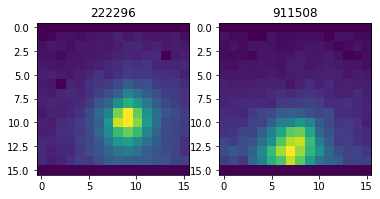

In [9]:
fig, ax = plt.subplots(1,2, figsize=(6,8))
ax[0].imshow(images[events[log_doubles[0]]['image_idx']].reshape(16,16))
ax[0].set_title(log_doubles[0])
ax[1].imshow(images[events[log_doubles[1]]['image_idx']].reshape(16,16))
ax[1].set_title(log_doubles[1])

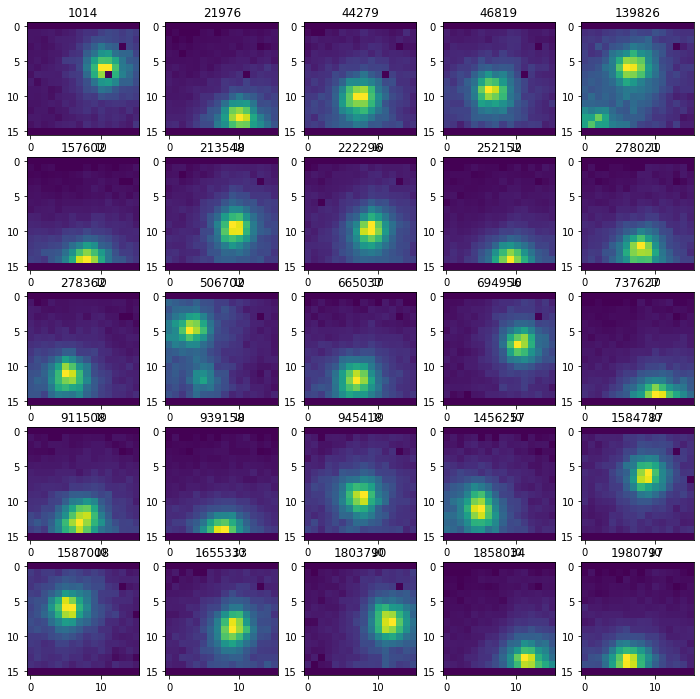

In [10]:
fig, ax = plt.subplots(5,5, figsize=(12,12))
for i, ev in enumerate(dense_doubles):
    ax.flatten()[i].imshow(images[events[ev]['image_idx']].reshape(16,16))
    ax.flatten()[i].set_title(ev)

In [ ]:
fig, ax = plt.subplots(20,5, figsize=(12,100))
for i, ev in enumerate(pretrained_doubles):
    ax.flatten()[i].imshow(images[events[ev]['image_idx']].reshape(16,16))
    ax.flatten()[i].set_title(ev)

# Check location of HIP for predicted doubles

In [11]:
pretrained_d_idx = np.array([pretrained_events[e_id]['image_idx'] for e_id in pretrained_doubles])
max_idx = images[pretrained_d_idx].reshape(images[pretrained_d_idx].shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[pretrained_d_idx].shape))
img = np.zeros(images[0].shape, dtype=int)
for el in maxpos_vect:
    img[el[1], el[2]] += 1

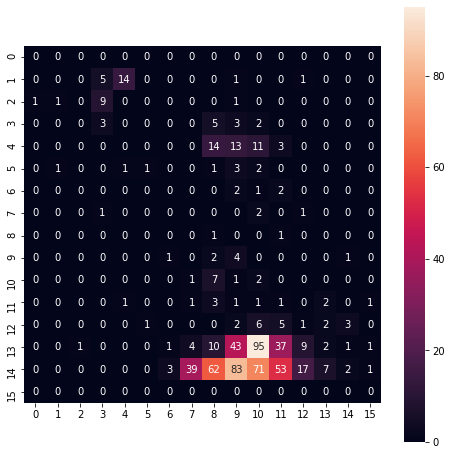

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(img.reshape(16,16), square=True, annot=True, fmt='d', ax=ax)